# Question 1
## Part 1, Dataset 2 (Ontario COVID Outcomes subset)
This portion of the report contains the steps taken to preprocess the COVID training dataset and implement the given tree-based methods (decision trees, random forest, and Gradient Tree Boost) on the data. The libraries used are from Scikit-learn (tree, ensemble, metrics) besides the four mentioned right below. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('covid_train.csv')

# Preprocessing:
The data was cleaned and converted to suitable formats before being fed into the predictors. Broadly speaking, the steps followed are:
1. Replacing or removing all Nan, i.e., missing entries- since the number of rows having missing entries (not counting Outbreak_Related) are small, they were directly removed.

2. Checking for typos and/or outliers in categorical fields. 

3. Use one-hot encoding to convert all categorical data to numerical; convert age to ordinal type.

4. Drop rows with remaining NaNs (missing values)


In [3]:
#Convert missing entries (NaN) in 'Outbreak_Related' to 'No':
df['Outbreak_Related'] = df['Outbreak_Related'].fillna('No')

In [4]:
#Look for any other missing values:
df.isnull().sum()

Age_Group                  6
Client_Gender              0
Case_AcquisitionInfo       0
Reporting_PHU_City         0
Outbreak_Related           0
Reporting_PHU_Latitude     0
Reporting_PHU_Longitude    0
Outcome1                   0
dtype: int64

In [5]:
#Checking for outliers and typos in Client_Gender:
df.Client_Gender.value_counts()

FEMALE            7499
MALE              7243
UNSPECIFIED        107
GENDER DIVERSE       2
Name: Client_Gender, dtype: int64

In [6]:
#Checking for outliers and typos in Case_AcquisitionInfo:
df.Case_AcquisitionInfo.value_counts()

OB                      5389
CC                      4115
MISSING INFORMATION     2952
NO KNOWN EPI LINK       2192
TRAVEL                   199
UNSPECIFIED EPI LINK       4
Name: Case_AcquisitionInfo, dtype: int64

In both gender and case info features, outliers can be observed (GENDER DIVERSE and UNSPECIFIED EPI LINK). However, since trees are known to be robust against such outliers, they are ignored. No typos were found in the searched features.

In [7]:
#Convert Outbreak_Related to binary values:
Outbreak_Related_map = {'Yes':1,'No':0}
df = df.replace({"Outbreak_Related":Outbreak_Related_map})

In [8]:
#Convert gender, acquisition info, cities to numerical type by one-hot encoding
catcolumns = ['Client_Gender','Case_AcquisitionInfo','Reporting_PHU_City']
df = pd.get_dummies(df,prefix=catcolumns,columns=catcolumns)

In [9]:
#Since number of missing entries is statistically insignificant, dropping rows with any NaN entries:
df = df.dropna()

In [10]:
#Replace Age_Group string values with ordinal values:
Age_Group_map = {'<20':1,'20s':2,'30s':3,'40s':4,'50s':5,'60s':6,'70s':7,'80s':8,'90s':9}
df = df.replace({"Age_Group":Age_Group_map})

Other design analyses made are the effects of dropping either the geo-coordinates or the cities feature (in its entirety). This is done by creating appropriate datasets.

## Training and Testing Datasets:
Three different training and testing sets are formed based on having all features or only a subset of them. All datasets are split into 70% training and 30% testing. Since cross-validation will be used, only one split to be done. 

In [11]:
#Getting training and testing datasets:

#all features-
X = df.drop(columns=['Outcome1'])
y = df['Outcome1'].to_list()

#without lat and long-
X_1 = df.drop(columns=['Outcome1','Reporting_PHU_Latitude','Reporting_PHU_Longitude'])

#with lat and long, but without cities-
df_nocities = df.iloc[:,:13]
X_2 = df_nocities.drop(columns=['Outcome1'])

#Splitting Training and Testing Data:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_1, y, test_size=0.3, random_state=0)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2, y, test_size=0.3, random_state=0)

## Decision Tree:

In [12]:
#Decision Tree Baseline:
from sklearn import tree
from sklearn import metrics

dt = tree.DecisionTreeClassifier(random_state=0)
dt_1 = tree.DecisionTreeClassifier(random_state=0)
dt_2 = tree.DecisionTreeClassifier(random_state=0)

dt_0 = dt.fit(X_train,y_train)
dt_01 = dt_1.fit(X_train1,y_train1)
dt_02 = dt_2.fit(X_train2,y_train2)

y_0 = dt.predict(X_test)
y_01 = dt_1.predict(X_test1)
y_02 = dt_2.predict(X_test2)

#Get accuracy score of models:
acc0 = metrics.accuracy_score(y_test,y_0)
acc01 = metrics.accuracy_score(y_test1,y_01)
acc02 = metrics.accuracy_score(y_test2,y_02)

acc = [acc0,acc01,acc02]
names = ['all features','no coords','no cities']
for i in [0,1,2]:
    print(names[i],"\t",acc[i],"\n")

all features 	 0.6479568926807364 

no coords 	 0.6517736865738661 

no cities 	 0.6468343062415806 



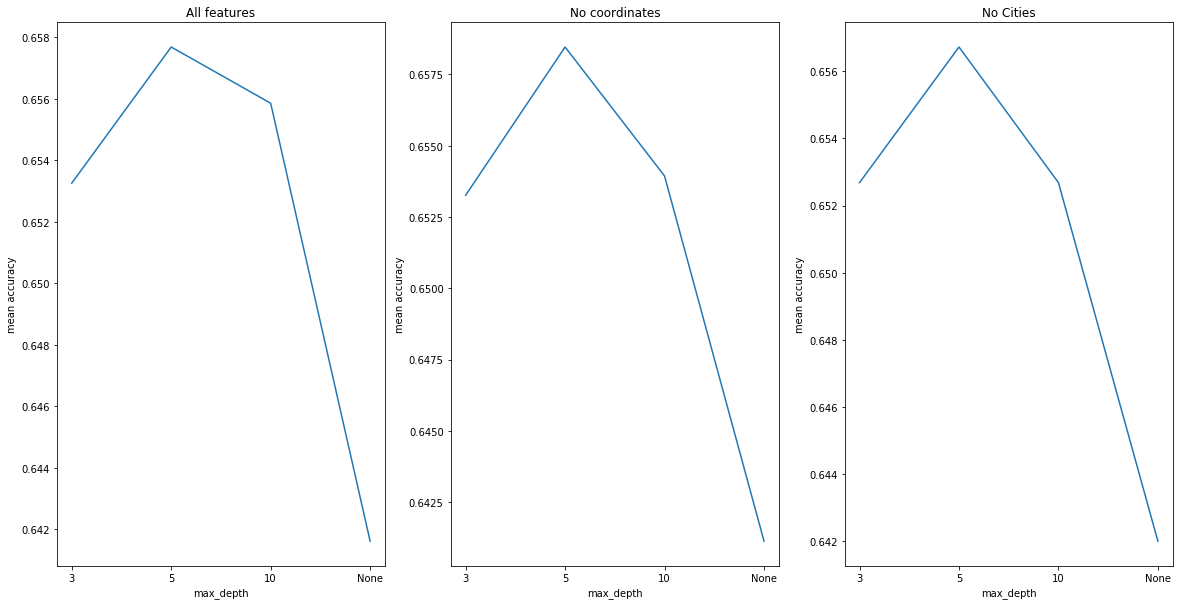

In [13]:
#Optimizing decision tree max_depth:
from sklearn import tree
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[3,5,10,None]}
dt = tree.DecisionTreeClassifier(random_state=0)
dt_clf = GridSearchCV(dt,parameters,scoring='accuracy',cv=10)
dt_clf_1 = GridSearchCV(dt,parameters,scoring='accuracy',cv=10)
dt_clf_2 = GridSearchCV(dt,parameters,scoring='accuracy',cv=10)

dt_clf.fit(X_train,y_train)
dt_clf_1.fit(X_train1,y_train1)
dt_clf_2.fit(X_train2,y_train2)

means = [dt_clf.cv_results_['mean_test_score'],dt_clf_1.cv_results_['mean_test_score'],dt_clf_2.cv_results_['mean_test_score']]
maxdepth = ['3','5','10','None']
fig = plt.figure(figsize=(20,10))
for i in [0,1,2]:
    fig.add_subplot(1,3,i+1)
    plt.plot(maxdepth,means[i])
    plt.xlabel('max_depth')
    plt.ylabel('mean accuracy')
    if i==0:
        plt.title('All features')
    if i==1:
        plt.title('No coordinates')
    if i==2:
        plt.title('No Cities')

From the plots above, there does not appear to be a marked difference between the full feature set and feature subsets in the case of the decision tree classifier. In all three cases, best parameters are max_depth = 5.
Considering the tree plot for analysis,

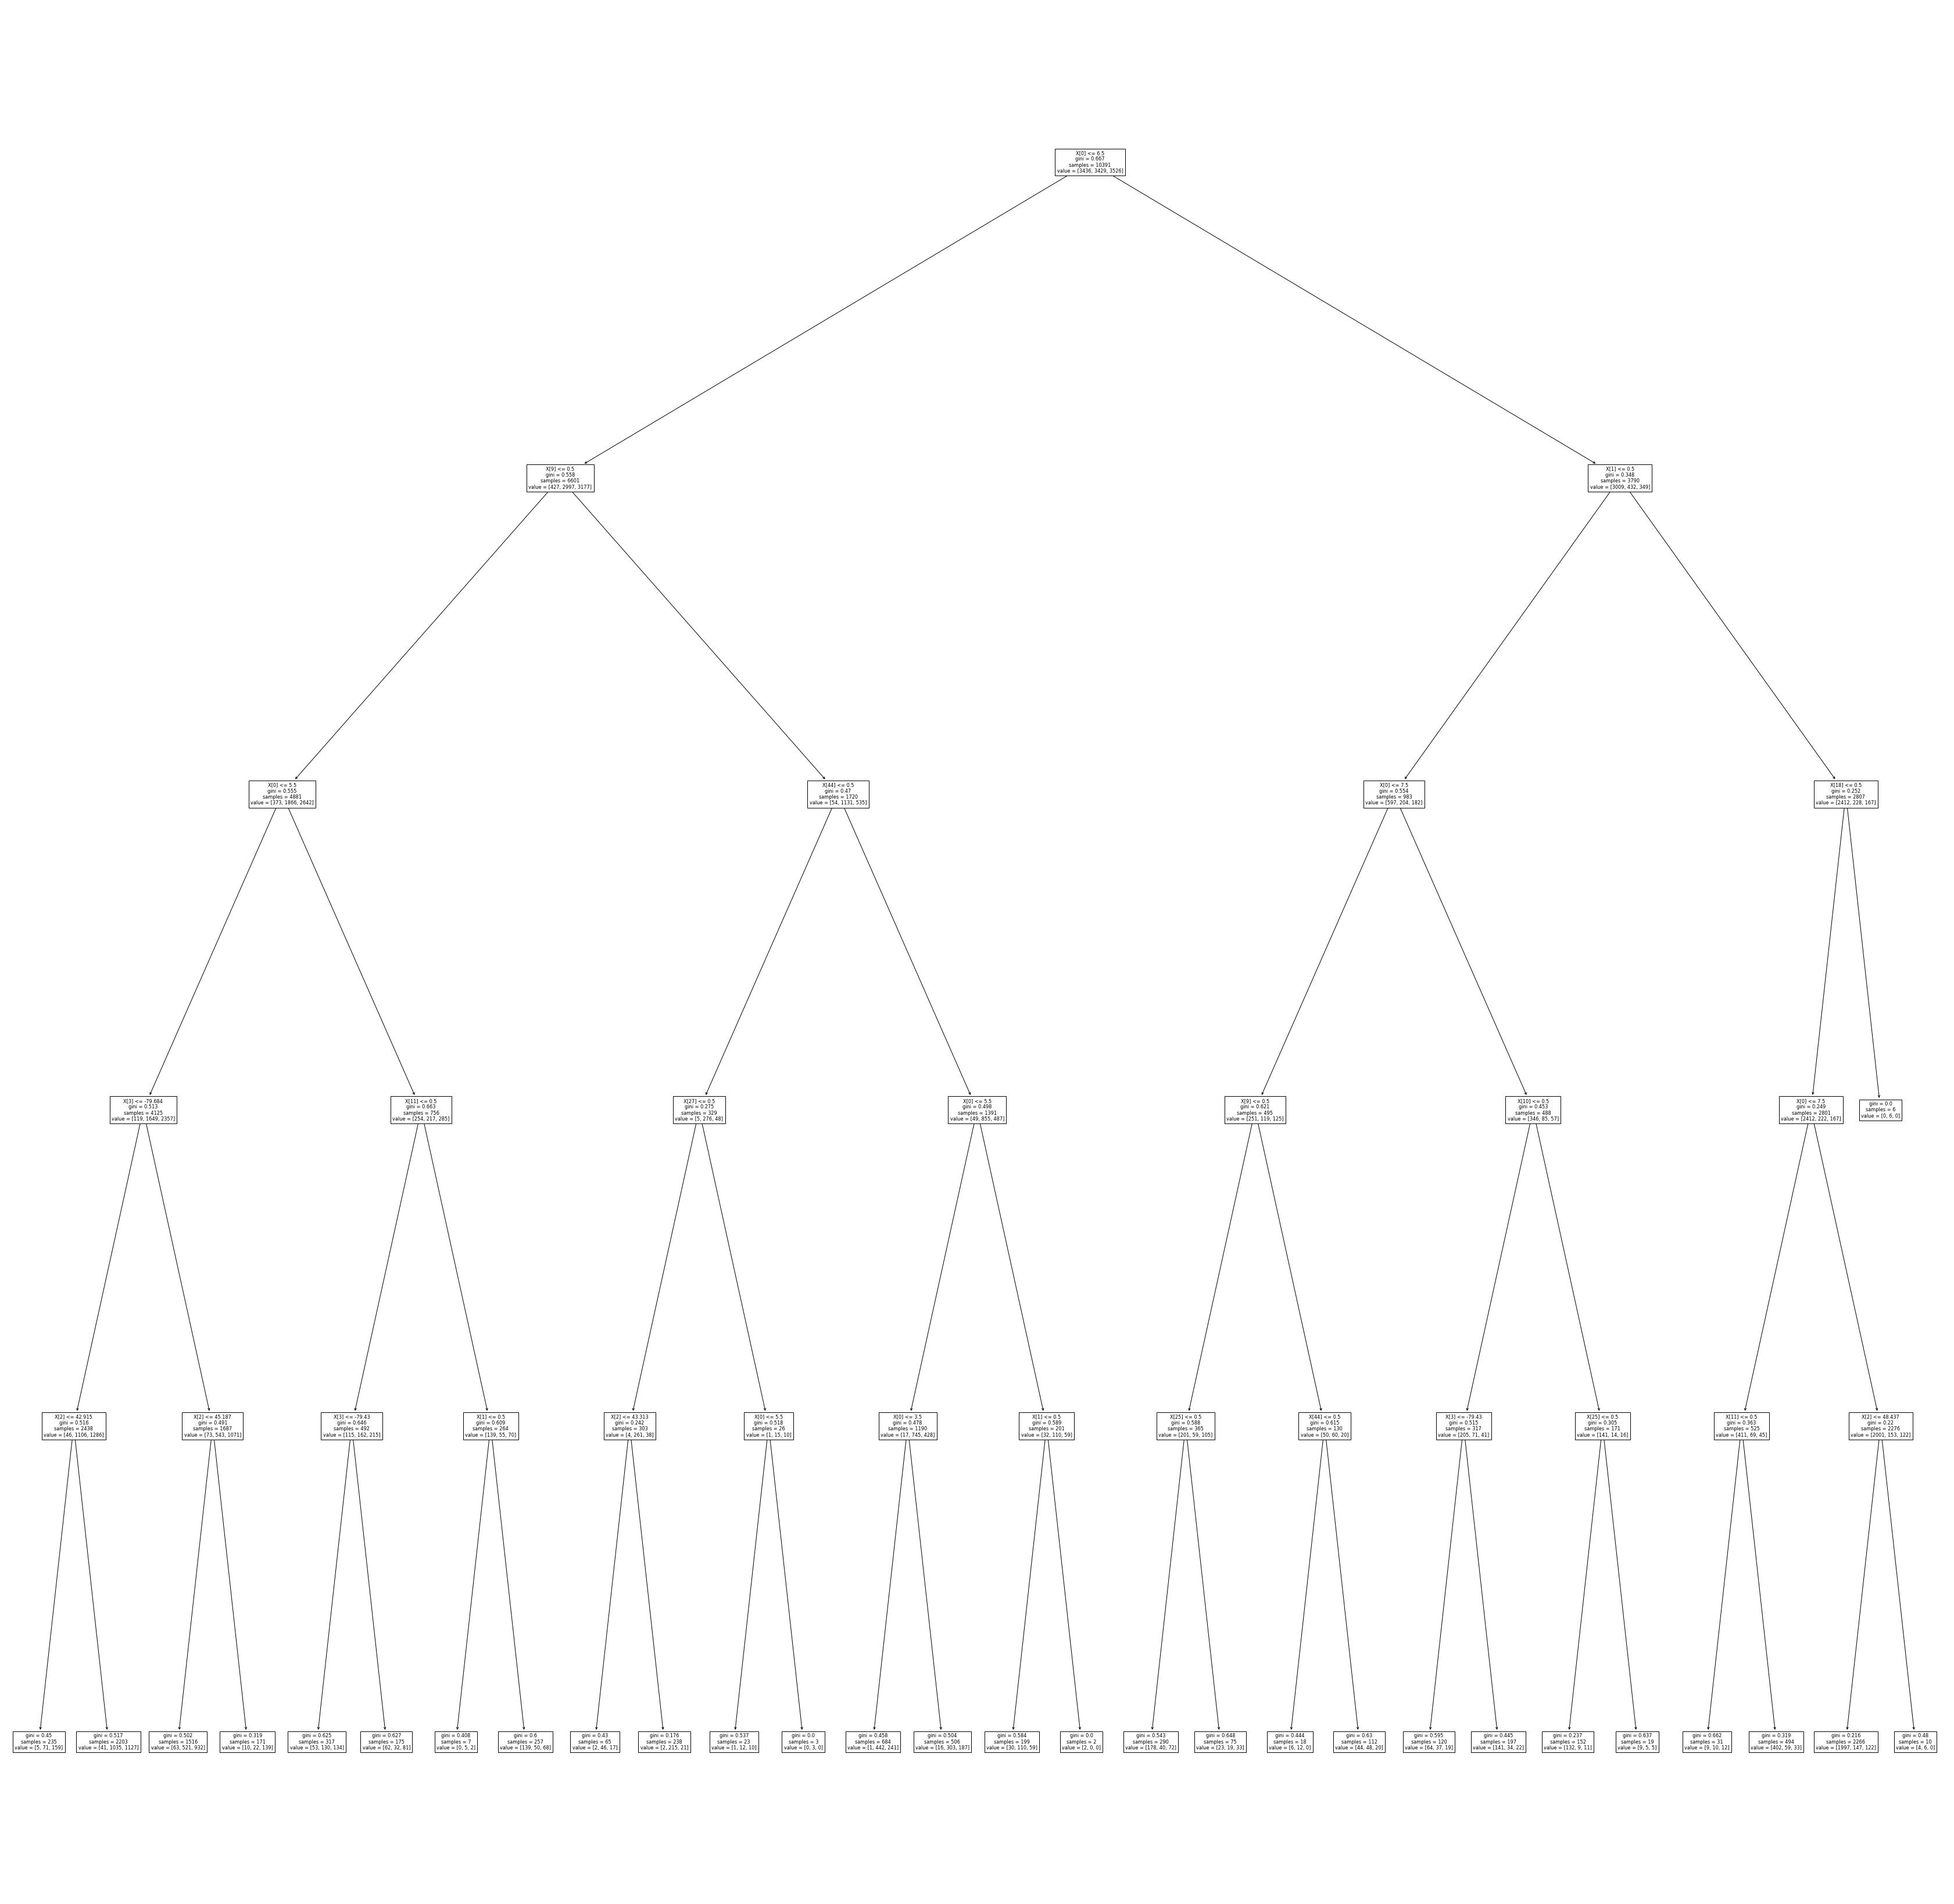

In [36]:
dt = tree.DecisionTreeClassifier(max_depth=5,random_state=0)
dtf = dt.fit(X_train,y_train)
fig = plt.figure(figsize=(60,60))
tree.plot_tree(dtf);

From the tree plot, we can observe the limits of the decision tree algorithm, as the classifier ends up unable to further reduce the gini disorder despite the final leaf gini values being somewhat high. In the diagram, the 0th feature, 'Age_Group' can be seen to have the most importance, clearly, seeing as it is the basis of the first split, and plays a significant role in splits further down across the board. Ordering the features based on importance (helpfulness in reducing gini) using the feature_importances_ parameters of the tree model,

Feature: 0, Score: 0.82837
Feature: 1, Score: 0.03053
Feature: 2, Score: 0.01362
Feature: 3, Score: 0.01757
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.07263
Feature: 10, Score: 0.00239
Feature: 11, Score: 0.01397
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00386
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00508
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00144
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

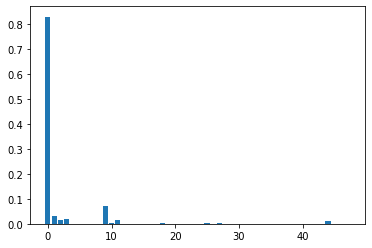

In [15]:
importance = dtf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

It is evident from both the plot and feature importance ranking that most of the features do not play a role in decision making (for splitting). Hence, even if all the features having score 0 were dropped, we would have the same result. Most of the accuracy of the model can be attributed to Age_Group. On the other hand, the relative importance of the 9th feature, that of Case_AcquisitionInfo_MISSING INFORMATION, it can be explained by the significant poortion caused perhaps by real-life data collection issues, where due to compilation of records from various sources, the type was not recorded properly.

Another point to note is that the extreme importance of Age_Group may be the reason for the poor performance of the algorithm, as such an imbalance in the feature would cause significant bias.

In [37]:
#Testing the DT model using testing set:
y_dtf = dtf.predict(X_test)
acc = metrics.accuracy_score(y_test,y_dtf)
acc

0.6576111360574765

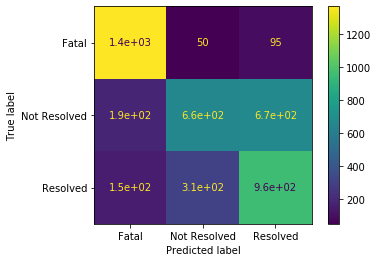

In [38]:
cm = metrics.confusion_matrix(y_test, y_pred,labels=dtf.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dtf.classes_)
disp.plot();

# Random Forest:
The random forest classification was carried out using the RandomForestClassifier from the sklearn.ensemble library. The baselines for all three training sets were found first, and tested for accuracy.

In [16]:
#Random Forest Baseline:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

rf = RandomForestClassifier(random_state=0)
rf_1 = RandomForestClassifier(random_state=0)
rf_2 = RandomForestClassifier(random_state=0)

rf_0 = rf.fit(X_train,y_train)
rf_01 = rf_1.fit(X_train1,y_train1)
rf_02 = rf_2.fit(X_train2,y_train2)

y_0 = rf.predict(X_test)
y_01 = rf_1.predict(X_test1)
y_02 = rf_2.predict(X_test2)

#Get accuracy score of models:
acc0 = metrics.accuracy_score(y_test,y_0)
acc01 = metrics.accuracy_score(y_test1,y_01)
acc02 = metrics.accuracy_score(y_test2,y_02)

acc = [acc0,acc01,acc02]
names = ['all features','no coords','no cities']
for i in [0,1,2]:
    print(names[i],"\t",acc[i],"\n")

all features 	 0.6513246519982039 

no coords 	 0.6535698248765155 

no cities 	 0.6531207903008531 



Similar to the resulting accuracies from the decision tree method, the three accuracies for the models do not increase by much, and do not show appreciable differences between them. The hyperparameters of the random forest classifier is tuned using sklearn functions:

In [17]:
#Optimizing random forest parameters:
parameters = {'n_estimators':[5,10,50,150,200],'max_depth':[3,5,10,None]}
rf = RandomForestClassifier(random_state=0)
rf_clf = GridSearchCV(rf,parameters,scoring='accuracy',cv=10)
rf_clf.fit(X_train,y_train);

In [18]:
#For no coordinates case-
rf_clf_1 = GridSearchCV(rf,parameters,scoring='accuracy',cv=10)
rf_clf_1.fit(X_train1,y_train1);

In [19]:
#For no cities case-
rf_clf_2 = GridSearchCV(rf,parameters,scoring='accuracy',cv=10)
rf_clf_2.fit(X_train2,y_train2);

In [20]:
#Getting accuracy scores for heat map
means = [rf_clf.cv_results_['mean_test_score'],rf_clf_1.cv_results_['mean_test_score'],rf_clf_2.cv_results_['mean_test_score']]

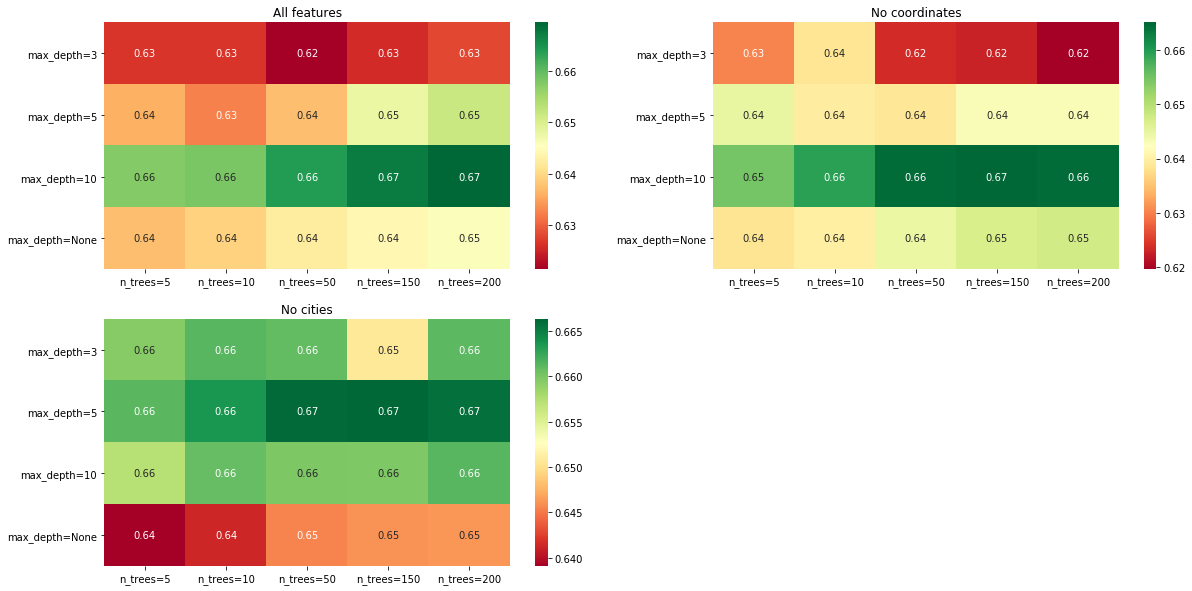

In [21]:
fig = plt.figure(figsize=(20,10))
rows = ['max_depth=3','max_depth=5','max_depth=10','max_depth=None']
cols = ['n_trees=5','n_trees=10','n_trees=50','n_trees=150','n_trees=200']
for i in [0,1,2]:
    rf_df = pd.DataFrame(means[i].reshape(4,5),columns=cols,index=rows)
    fig.add_subplot(2,2,i+1)
    sns.heatmap(rf_df,annot=True,cmap="RdYlGn");
    if i==0:
        plt.title('All features')
    if i==1:
        plt.title('No coordinates')
    if i==2:
        plt.title('No cities')

The heat maps of the (max_depth x n_trees) table of results for mean accuracy are shown above. From the results of the grid search, the best parameters for each training set:

In [22]:
#Best parameters for the three use cases:
bp = rf_clf.best_params_
bp1 = rf_clf_1.best_params_
bp2 = rf_clf_2.best_params_
btemp = [bp,bp1,bp2]
names = ['all features','no coords','no cities']
for i in [0,1,2]:
    print(names[i],"\t",btemp[i],"\n")

all features 	 {'max_depth': 10, 'n_estimators': 200} 

no coords 	 {'max_depth': 10, 'n_estimators': 150} 

no cities 	 {'max_depth': 5, 'n_estimators': 150} 



In [23]:
#Prediction score of 'all features' trained model on testing set:
yQ = rf_clf.predict(X_test)
acc = metrics.accuracy_score(y_test,yQ)
acc

0.6710821733273462

## Gradient Tree Boosting:
The gradient boosting classification was carried out using the GradientBoostingClassifier from the sklearn.ensemble library. The baselines for all three training sets were found first, and tested for accuracy. The number of trees parameter of the classifier was then tuned using GridSearchCV, optimized based on accuracy and with 10-fold cross-validation. The mean accuracy scores were plotted against the number of estimators.

In [24]:
#Gradient Tree Boosting Baseline:
from sklearn.ensemble import GradientBoostingClassifier

gb0 = GradientBoostingClassifier(random_state=0)

gb_0 = gb0.fit(X_train,y_train)
y_0 = gb0.predict(X_test)
#Get accuracy score of model:
acc0 = metrics.accuracy_score(y_test,y_0)
acc0

0.6713066906151773

In [25]:
#optimizing parameters for gradient tree boosting:
parameters = {'n_estimators':[5,10,50,150,200]}
gb = GradientBoostingClassifier(random_state=0)
gb_clf = GridSearchCV(gb,parameters,scoring='accuracy',cv=10)
gb_clf.fit(X_train,y_train)
means_gb = gb_clf.cv_results_['mean_test_score']

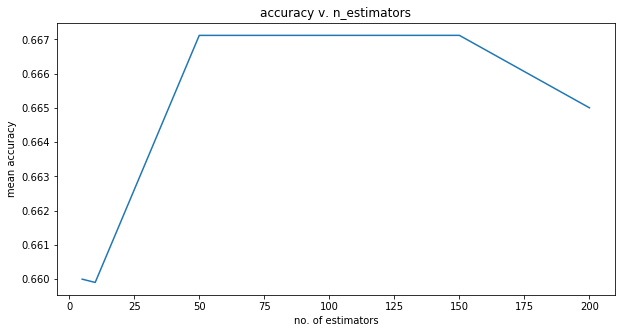

In [26]:
n_estimators = [5,10,50,150,200]
fig = plt.figure(figsize=(10,5))
plt.plot(n_estimators,means_gb)
plt.xlabel('no. of estimators')
plt.ylabel('mean accuracy')
plt.title('accuracy v. n_estimators');

In [27]:
#Best parameters:
gb_clf.best_params_

{'n_estimators': 150}

In [28]:
#Testing model on test dataset
y_pred = gb_clf.predict(X_test)
acc = metrics.accuracy_score(y_test,y_pred)
acc #accuracy:

0.6717557251908397

## For Question 1, part 2:

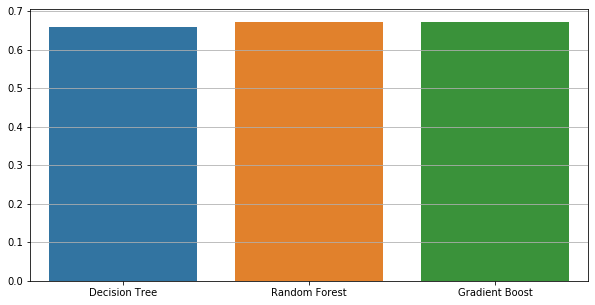

In [29]:
#Plot accuracies of each method in bar plot:
y1 = dt_clf.predict(X_test)
y2 = rf_clf.predict(X_test)
y3 = gb_clf.predict(X_test)
#Get accuracy score of models:
ac1 = metrics.accuracy_score(y_test,y1)
ac2 = metrics.accuracy_score(y_test,y2)
ac3 = metrics.accuracy_score(y_test,y3)
#Plot barplot:
fig = plt.figure(figsize=(10,5))
plt.grid(b=True)
meandata = pd.DataFrame([[ac1,ac2,ac3]],columns=['Decision Tree','Random Forest','Gradient Boost'])
ax = sns.barplot(data=meandata)

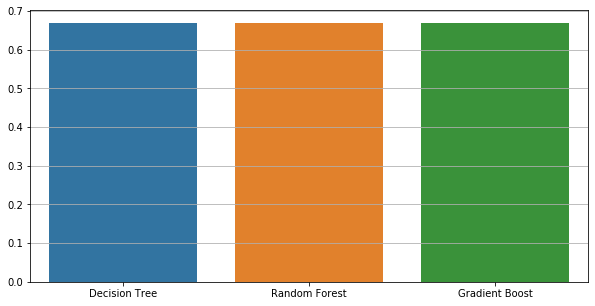

In [35]:
#Get precision score of models:
ac1 = metrics.precision_score(y_test,y1,average='macro')
ac2 = metrics.precision_score(y_test,y2,average='macro')
ac3 = metrics.precision_score(y_test,y3,average='macro')
#Plot barplot:
fig = plt.figure(figsize=(10,5))
plt.grid(b=True)
meandata = pd.DataFrame([[ac1,ac2,ac3]],columns=['Decision Tree','Random Forest','Gradient Boost'])
ax = sns.barplot(data=meandata)

# Question 2: Naive Bayes Classifier
## Part 1, Dataset 2(Ontario COVID Outcomes Subset)
For the COVID dataset, which has 4 categorical variables, the Gaussian Naive Bayes is not quite appropriate. On the other hand, the Categorical Naive Bayes cannot accomodate the coordinates. Based on this, both the classifiers from the sklearn.naive_bayes library are tried and the performance of the classifiers are reported.

In [284]:
#Categorical Naive Bayes-preprocessing:
df = pd.read_csv('covid_train.csv')
df['Outbreak_Related'] = df['Outbreak_Related'].fillna('No')

Outbreak_Related_map = {'Yes':1,'No':0}
df = df.replace({"Outbreak_Related":Outbreak_Related_map})

#Convert gender, acquisition info, cities to numerical type
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le1 = preprocessing.LabelEncoder()
le2 = preprocessing.LabelEncoder()
df.Client_Gender = le.fit_transform(df.Client_Gender)
df.Case_AcquisitionInfo = le1.fit_transform(df.Case_AcquisitionInfo)
df.Reporting_PHU_City = le2.fit_transform(df.Reporting_PHU_City)

#Replace Age_Group string values with ordinal values:
Age_Group_map = {'<20':1,'20s':2,'30s':3,'40s':4,'50s':5,'60s':6,'70s':7,'80s':8,'90s':9}
df = df.replace({"Age_Group":Age_Group_map})

df = df.dropna()

X_cnb = df.drop(columns=['Reporting_PHU_Latitude','Reporting_PHU_Longitude','Outcome1'])
y_cnb = df['Outcome1'].to_list()

X_train, X_test, y_train, y_test = train_test_split(X_cnb, y_cnb, test_size=0.3, random_state=0)

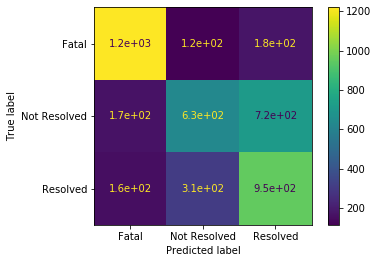

In [285]:
#Baseline Categorical NB:
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import confusion_matrix

cnb = CategoricalNB()
cnb.fit(X_train,y_train)
y_pred = cnb.predict(X_test)
acc = metrics.accuracy_score(y_test,y_pred)

cm = confusion_matrix(y_test, y_pred,labels=cnb_clf.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=cnb_clf.classes_)
disp.plot();

In [286]:
acc

0.6299955096542433

In [287]:
#Tuning Naive Bayes classifier parameters
parameters = {"alpha":[1e-10, 1e-9, 1e-5, 1e-3, 1e-1,1]}
cnb = CategoricalNB()
cnb_clf = GridSearchCV(cnb,parameters,scoring='accuracy',cv=10)
cnb_clf.fit(X_train,y_train)
means_cnb = cnb_clf.cv_results_['mean_test_score']

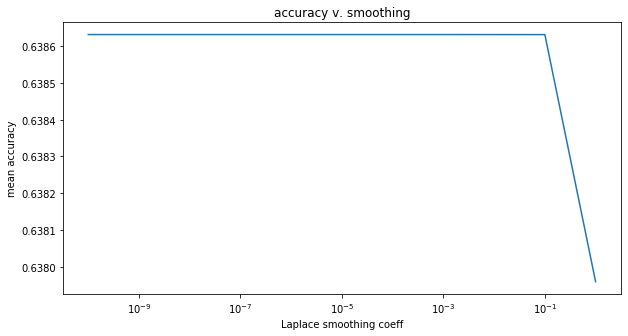

In [288]:
Laplace_smoothing=[1e-10, 1e-9, 1e-5, 1e-3, 1e-1,1]
fig = plt.figure(figsize=(10,5))
plt.plot(Laplace_smoothing,means_cnb)
plt.xscale('log')
plt.xlabel('Laplace smoothing coeff')
plt.ylabel('mean accuracy')
plt.title('accuracy v. smoothing');

In [289]:
cnb_clf.best_params_

{'alpha': 1e-10}

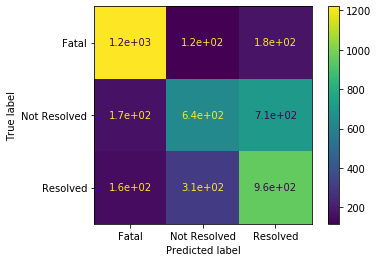

In [290]:
#Accuracy of CategoricalNB on Testing Set
y_pred = cnb_clf.predict(X_test)
acc = metrics.accuracy_score(y_test,y_pred)

cm = confusion_matrix(y_test, y_pred,labels=cnb_clf.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=cnb_clf.classes_)
disp.plot();

In [291]:
#Accuracy:
acc

0.6308935788055681

There was an improvement of accuracy test score from 62.9% to 63.08% through tuning, which is not quite significant. The distribution of values in the confusion matrix are also distinctly similar.

In [46]:
#Gaussian Naive Bayes Preprocessing:
df = pd.read_csv('covid_train.csv')
df['Outbreak_Related'] = df['Outbreak_Related'].fillna('No')

Outbreak_Related_map = {'Yes':1,'No':0}
df = df.replace({"Outbreak_Related":Outbreak_Related_map})

#Convert gender, acquisition info, cities to numerical type by one-hot encoding
catcolumns = ['Client_Gender','Case_AcquisitionInfo','Reporting_PHU_City']
df = pd.get_dummies(df,prefix=catcolumns,columns=catcolumns)

df = df.dropna()

#Replace Age_Group string values with ordinal values:
Age_Group_map = {'<20':1,'20s':2,'30s':3,'40s':4,'50s':5,'60s':6,'70s':7,'80s':8,'90s':9}
df = df.replace({"Age_Group":Age_Group_map})

X_gnb = df.drop(columns=['Outcome1'])
y_gnb = df['Outcome1'].to_list()

X_train, X_test, y_train, y_test = train_test_split(X_gnb, y_gnb, test_size=0.3, random_state=0)

#To normalize the datasets:
from sklearn.preprocessing import Normalizer
norm = Normalizer() #Works on each sample independantly and hence does not bias model towards testing set
n_X_train = norm.fit_transform(X_train)
n_X_test = norm.fit_transform(X_test)

In [52]:
#Baseline Gaussian Naive Bayes:
from sklearn.naive_bayes import GaussianNB
gnb0 = GaussianNB()
y_pred0 = gnb0.fit(X_train, y_train).predict(X_test)
#Get accuracy score of model:
acc0 = metrics.accuracy_score(y_test,y_pred0)
acc0

0.369106421194432

In [53]:
#Tuning Naive Bayes classifier parameters
parameters = {"var_smoothing":[1e-10, 1e-9, 1e-5, 1e-3, 1e-1]}
gnb = GaussianNB()
gnb_clf = GridSearchCV(gnb,parameters,scoring='accuracy',cv=10)
gnb_clf.fit(n_X_train,y_train)
means_gnb = gnb_clf.cv_results_['mean_test_score']

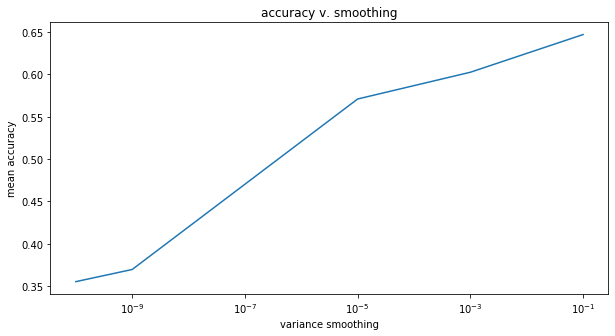

In [54]:
variance_smoothing=[1e-10, 1e-9, 1e-5, 1e-3, 1e-1]
fig = plt.figure(figsize=(10,5))
plt.plot(variance_smoothing,means_gnb)
plt.xscale('log')
plt.xlabel('variance smoothing')
plt.ylabel('mean accuracy')
plt.title('accuracy v. smoothing');

In [55]:
gnb_clf.best_params_

{'var_smoothing': 0.1}

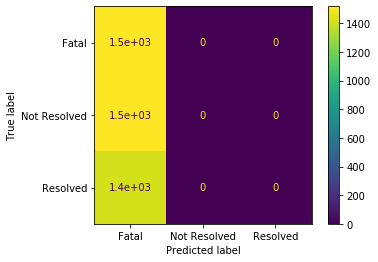

In [58]:
#Accuracy of GaussianNB on Testing Set
y_pred = gnb_clf.predict(X_test)
acc = metrics.accuracy_score(y_test,y_pred)

cm = metrics.confusion_matrix(y_test, y_pred,labels=gnb_clf.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gnb_clf.classes_)
disp.plot();

### Impact of variance smoothing:
By specifying a value for var_smoothing, we are adding artificial variance to the natural variance of the distribution, thereby accounting for majority of the data, "smoothing" out the curve and blurring existing boundaries. On the other hand, laplace smoothing (alpha > 0) in case of categorical naive bayes does something similar, however, it helps avoid calculation errors from getting probability = 0. It also helps put together sparse categories which makes it work better under such data conditions.